### Import the packages

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# for the polygon intersections
import shapely.geometry as sg
import descartes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.feature as cfeature
#from xgcm import Grid

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

# for gsw
import sys
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
import gsw

from scipy.interpolate import interpn
from shapely.ops import unary_union
from shapely import Point

### Load data and WMT

In [2]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

In [3]:
# load the sliced data from polynyas
# write these to files? does this save time
xgrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/xgrid_dsw.txt",sep=",")
ygrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/ygrid_dsw.txt",sep=",")
xgrid = xgrid.reshape((35040,-1))
ygrid = ygrid.reshape((35040,-1))
temp = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/temp_dsw.txt",sep=",")
salt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/salt_dsw.txt",sep=",")
depth = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/depth_dsw.txt",sep=",")
temp = temp.reshape((35040,-1))
depth = depth.reshape((35040,-1))
salt = salt.reshape((35040,-1))

In [4]:
wmt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt_dsw.txt",sep=",")
wmt = wmt.reshape((35040,-1))

In [5]:
# or load from the grouping of 4 files
# load with 4 groups
group1 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group1_dsw.txt",sep=",")
group2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group2_dsw.txt",sep=",")
group4 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group3_dsw.txt",sep=",")
group3 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/GroupFiles/group4_dsw.txt",sep=",")

group1 = group1.tolist()
group1 = [int(x) for x in group1]
group2 = group2.tolist()
group2 = [int(x) for x in group2]
group3 = group3.tolist()
group3 = [int(x) for x in group3]
group4 = group4.tolist()
group4 = [int(x) for x in group4]

groups = np.array([group1,group2,group3,group4],dtype=object)

In [6]:
pollocs2 = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/pollocs_dsw.txt",sep=",",dtype=int)
pollocs2.shape

(4458,)

### Create the lat and long values

In [7]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

stack = np.stack((ygrid, xgrid), axis=-1)
lat2 = interpn((ybins,xbins),lat_values,stack)
long2 = interpn((ybins,xbins),long_values,stack)

### Classic view as done in Thesis

In [8]:
# THESE ARE IN GRID POINTS
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:olive"])
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]

0
1
2
3


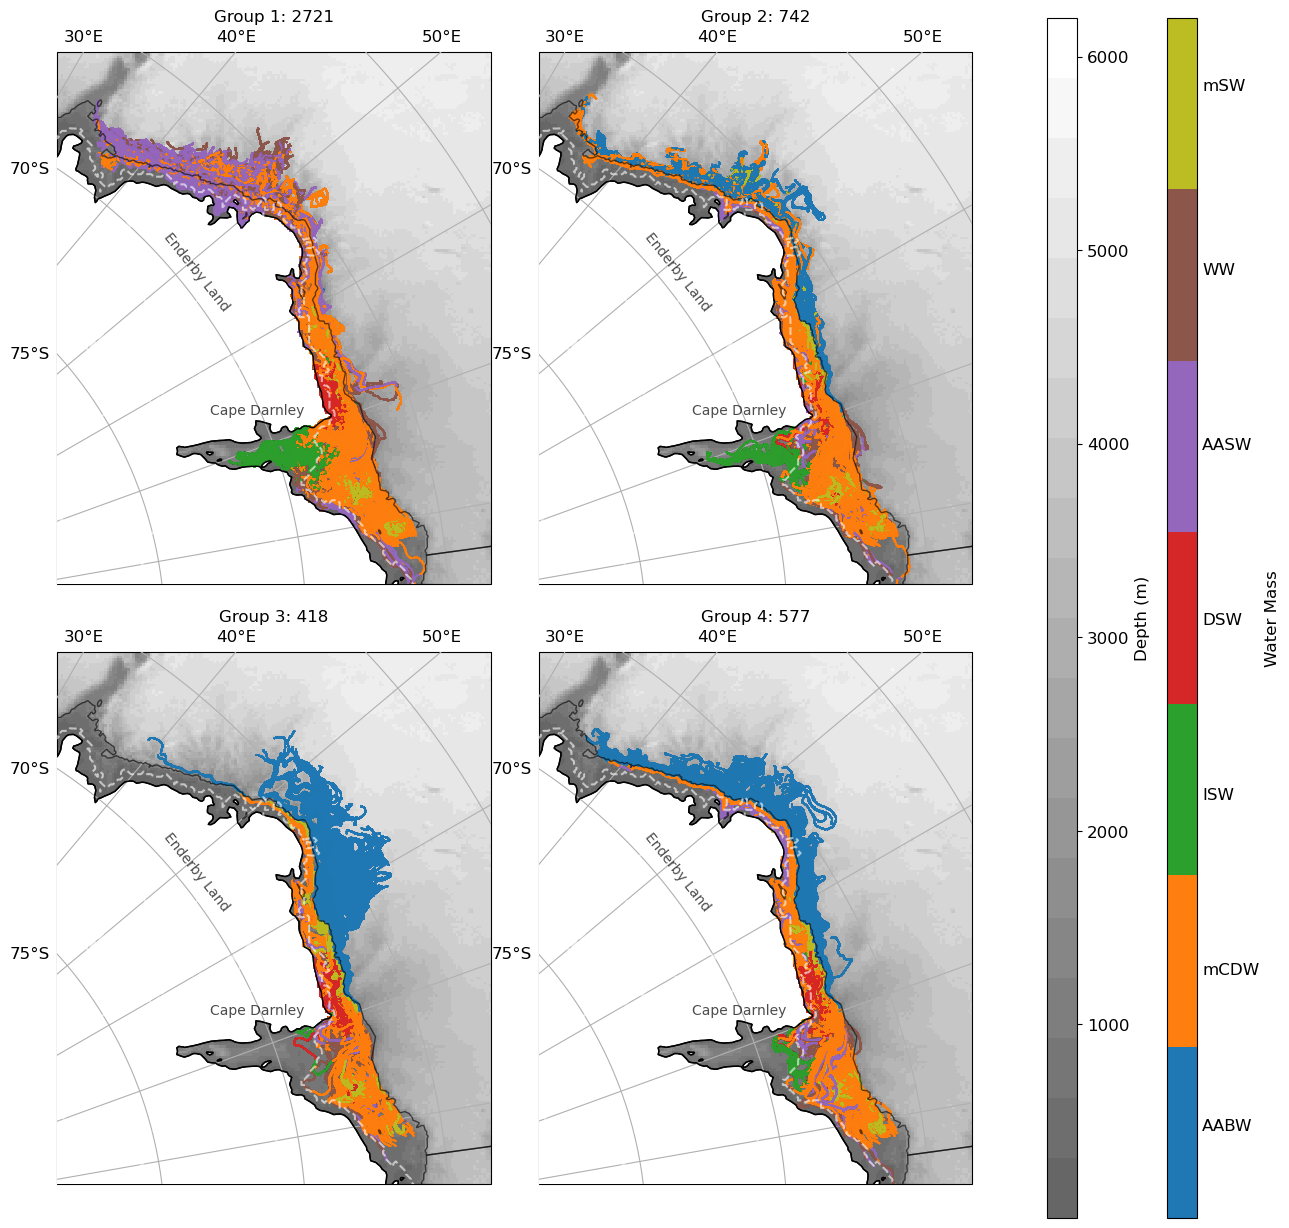

In [9]:
# fig, axes = plt.subplots(figsize=(15,15),nrows=3, ncols=2,sharex=True,sharey=True,subplot_kw={'projection': proj})
fig, axes = plt.subplots(figsize=(15,15),nrows=2, ncols=2,sharex=True,sharey=True,subplot_kw={'projection': proj})

fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 12})
i = 0

for ax,group in zip(axes.flat,groups):
    print(i)

    ax.title.set_text("Group " + str(i+1) + ": "+ str(len(groups[i])))
    pcm = ax.scatter(long2[:,groups[i]],lat2[:,groups[i]],marker='.',s=0.1,zorder=5,
                c=wmt[:,groups[i]],cmap=cmap,transform=ccrs.PlateCarree(),rasterized=True)
    
    cm_d = ax.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),
                         cmap=plt.get_cmap('gray',20),alpha=0.6)
    ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
    
    # add ice shelf and continental shelf
    ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='solid', linewidth=1,alpha=0.6,zorder=6)
    ax.contour(dg.lon_rho[1:,300:], dg.lat_rho[1:,300:],ds1.zice[1:,300:],levels=[-0.2],
            zorder=6,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=plt.get_cmap('gray_r'),alpha=0.6)
    
    # add the colorbar and lat/long ticks
    #cbar = plt.colorbar(label="Bathymetry (m)",extend='max',location='left')
    gl = ax.gridlines(zorder=3,draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.rotate_labels = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.ylocator = mticker.FixedLocator(np.arange(-50,-90,-5))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,edgecolor='black', facecolor='white',zorder=3)
    plt.xlim([1250000,3000000])
    plt.ylim([200000,2350000])
    
    # try to add labels
    ax.text(x=52, y=-71.2,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-51.5,fontsize=10,alpha=0.7,zorder=10)
    ax.text(x=64.65, y=-71.65,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=10,alpha=0.7,zorder=10)
    
    i += 1
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.7,wspace=0.11, hspace=0)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(pcm,label="Water Mass",cax = cb_ax,ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
cbar.ax.tick_params(labelsize=12, length=0)

bounds = np.array([0,1,2,3,4,5])
# cbar.set_ticks([0.5,1.3,2.175,3.05,3.925,4.8,5.675])
cbar.set_ticks([0.5,1.25,2.125,3,3.875,4.75,5.625])
tick_texts = cbar.ax.set_yticklabels(labels)
tick_texts[0].set_verticalalignment('top')
tick_texts[-1].set_verticalalignment('bottom')

cb_ax2 = fig.add_axes([0.75,0.1,0.02,0.8])
cbar2 = fig.colorbar(cm_d,label="Depth (m)",cax = cb_ax2)

plt.savefig("/scratch/project_2000789/muramarg/floats_WAOM/FINAL/dsw/wmt_euler.png", dpi=300)